# Evaluation of features 
1. comparison to clustering of gene space
2. silhouette score to evaluation "clusterability" of different features



In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from spatial_tools.image.tools import get_image_features

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)

adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Preprocess genes and calculate gene-space clustering

<AxesSubplot:xlabel='n_genes_by_counts'>

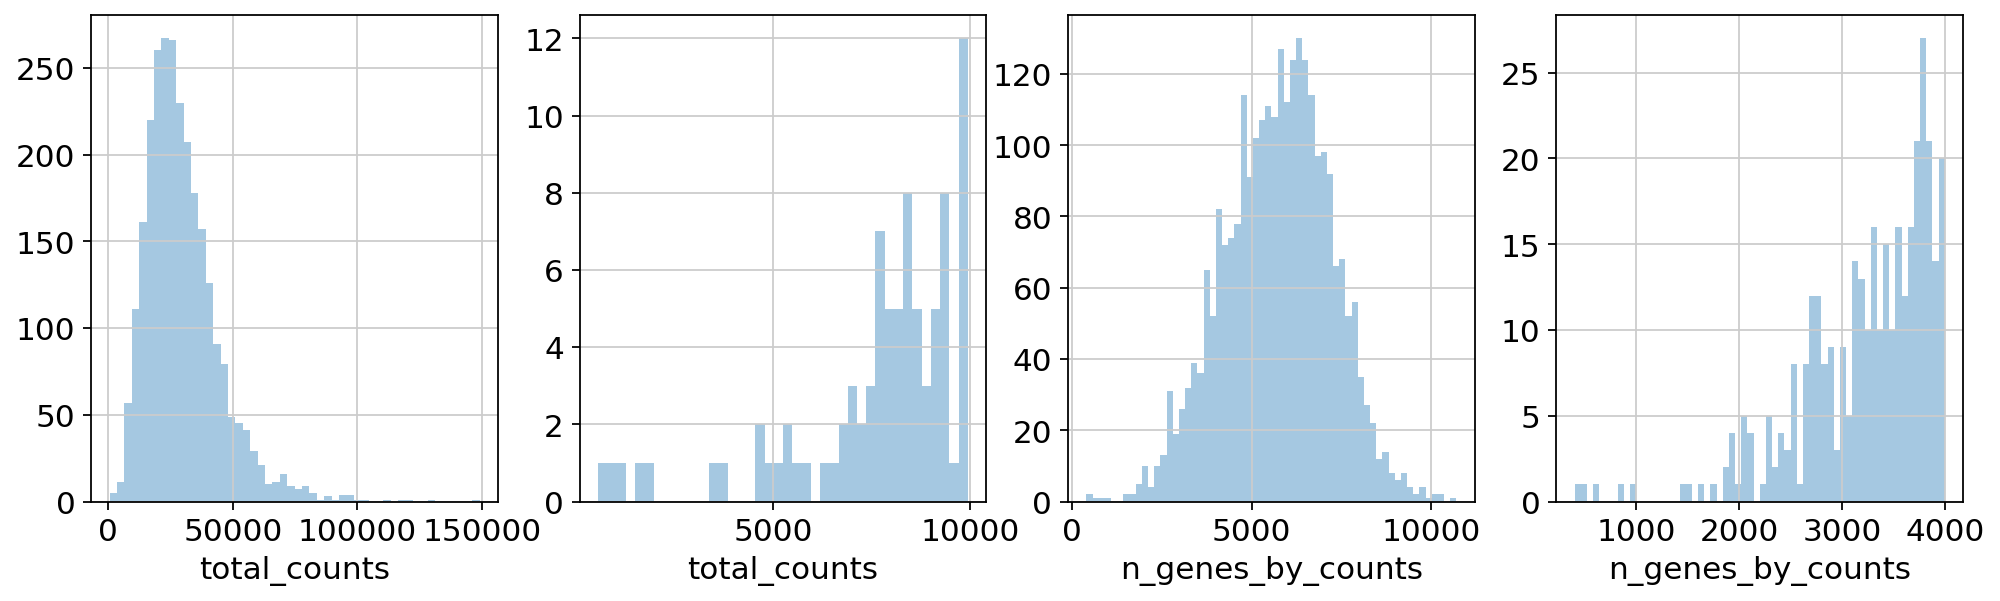

In [15]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

data looks fine, no thresholding needed for now.
Normalize data.

In [16]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

calculate gene-space clustering

In [17]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters_genes")

/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Calculate features + feature-space clustering

#### The code below creates crop feature combinations and add each settings features and adds them to the adata object. following each feature in dim reduced for comparison. 


TODO: add clustering evaluation score to see how the difference crop settings change the cluster quality. NOTE: multi threading most likely necessary here to speed up.

In [8]:
import itertools as it

def cluster_features(adata, feature_name):
    '''
    adata: scanpy adata object
    feature_name: str with all crop settings
    '''
    adata.obsm[feature_name + "_pca"] = sc.pp.pca(adata.obsm[feature_name])
    sc.pp.neighbors(adata, use_rep=feature_name + "_pca")
    adata.obsm[feature_name + '_umap'] = sc.tl.umap(adata, copy=True).obsm['X_umap']
    sc.tl.leiden(adata, key_added=feature_name + '_clusters_features')


features = ["texture", "summary", "color_hist", "hog"]
adata = adata[0:10]
crop_parameters = {"sizef": [1, 1.5, 2], "scalef": [1, 0.5, 0.25], "mask_circle": [False, True]}
combinations = it.product(*(crop_parameters[Name] for Name in crop_parameters))


for combination in list(combinations):
    sizef, scalef, mask_circle = combination
    
    adata.obsm[feature_name] = get_image_features(adata, dataset_folder, dataset_name, 
                                                  features=["summary", "texture", "color_hist"],
                                                  sizef=sizef, 
                                                  scalef=scalef, 
                                                  mask_circle=mask_circle)  

# repeat the process but now clustering all the features
combinations = it.product(*(crop_parameters[Name] for Name in crop_parameters))

for combination in list(combinations):
    feature_name = f"image_features_size-{sizef}_scale{scalef}_circle-{mask_circle}"
    
    # cluster the features
    cluster_features(adata, feature_name)


10it [00:00, 19.20it/s]
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
10it [00:00, 17.01it/s]
10it [00:00, 19.27it/s]
10it [00:00, 18.90it/s]
10it [00:00, 19.36it/s]
10it [00:00, 19.08it/s]
10it [00:00, 18.69it/s]
10it [00:00, 18.03it/s]
10it [00:00, 18.31it/s]
10it [00:00, 18.00it/s]
10it [00:00, 18.63it/s]
10it [00:00, 18.25it/s]
10it [00:00, 17.06it/s]
10it [00:00, 16.26it/s]
10it [00:00, 16.69it/s]
10it [00:00, 16.33it/s]
10it [00:00, 17.18it/s]
10it [00:00, 17.08it/s]


In [11]:
#### extract features for one example

adata.obsm[feature_name] = get_image_features(adata, dataset_folder, dataset_name, 
                                                  features=["summary", "texture", "color_hist"],
                                                  sizef=1, 
                                                  scalef=1, 
                                                  mask_circle=True) 

2698it [02:22, 18.96it/s]


In [12]:
adata.obsm["feature" + "_pca"] = sc.pp.pca(adata.obsm[feature_name])
sc.pp.neighbors(adata, use_rep="feature" + "_pca")
adata.obsm["feature" + '_umap'] = sc.tl.umap(adata, copy=True).obsm['X_umap']
sc.tl.leiden(adata, key_added='clusters_features')

/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Plot resulting clusters

In [ ]:
sc.pl.spatial?

#### "hog", "texture", "summary", "color_hist"

/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


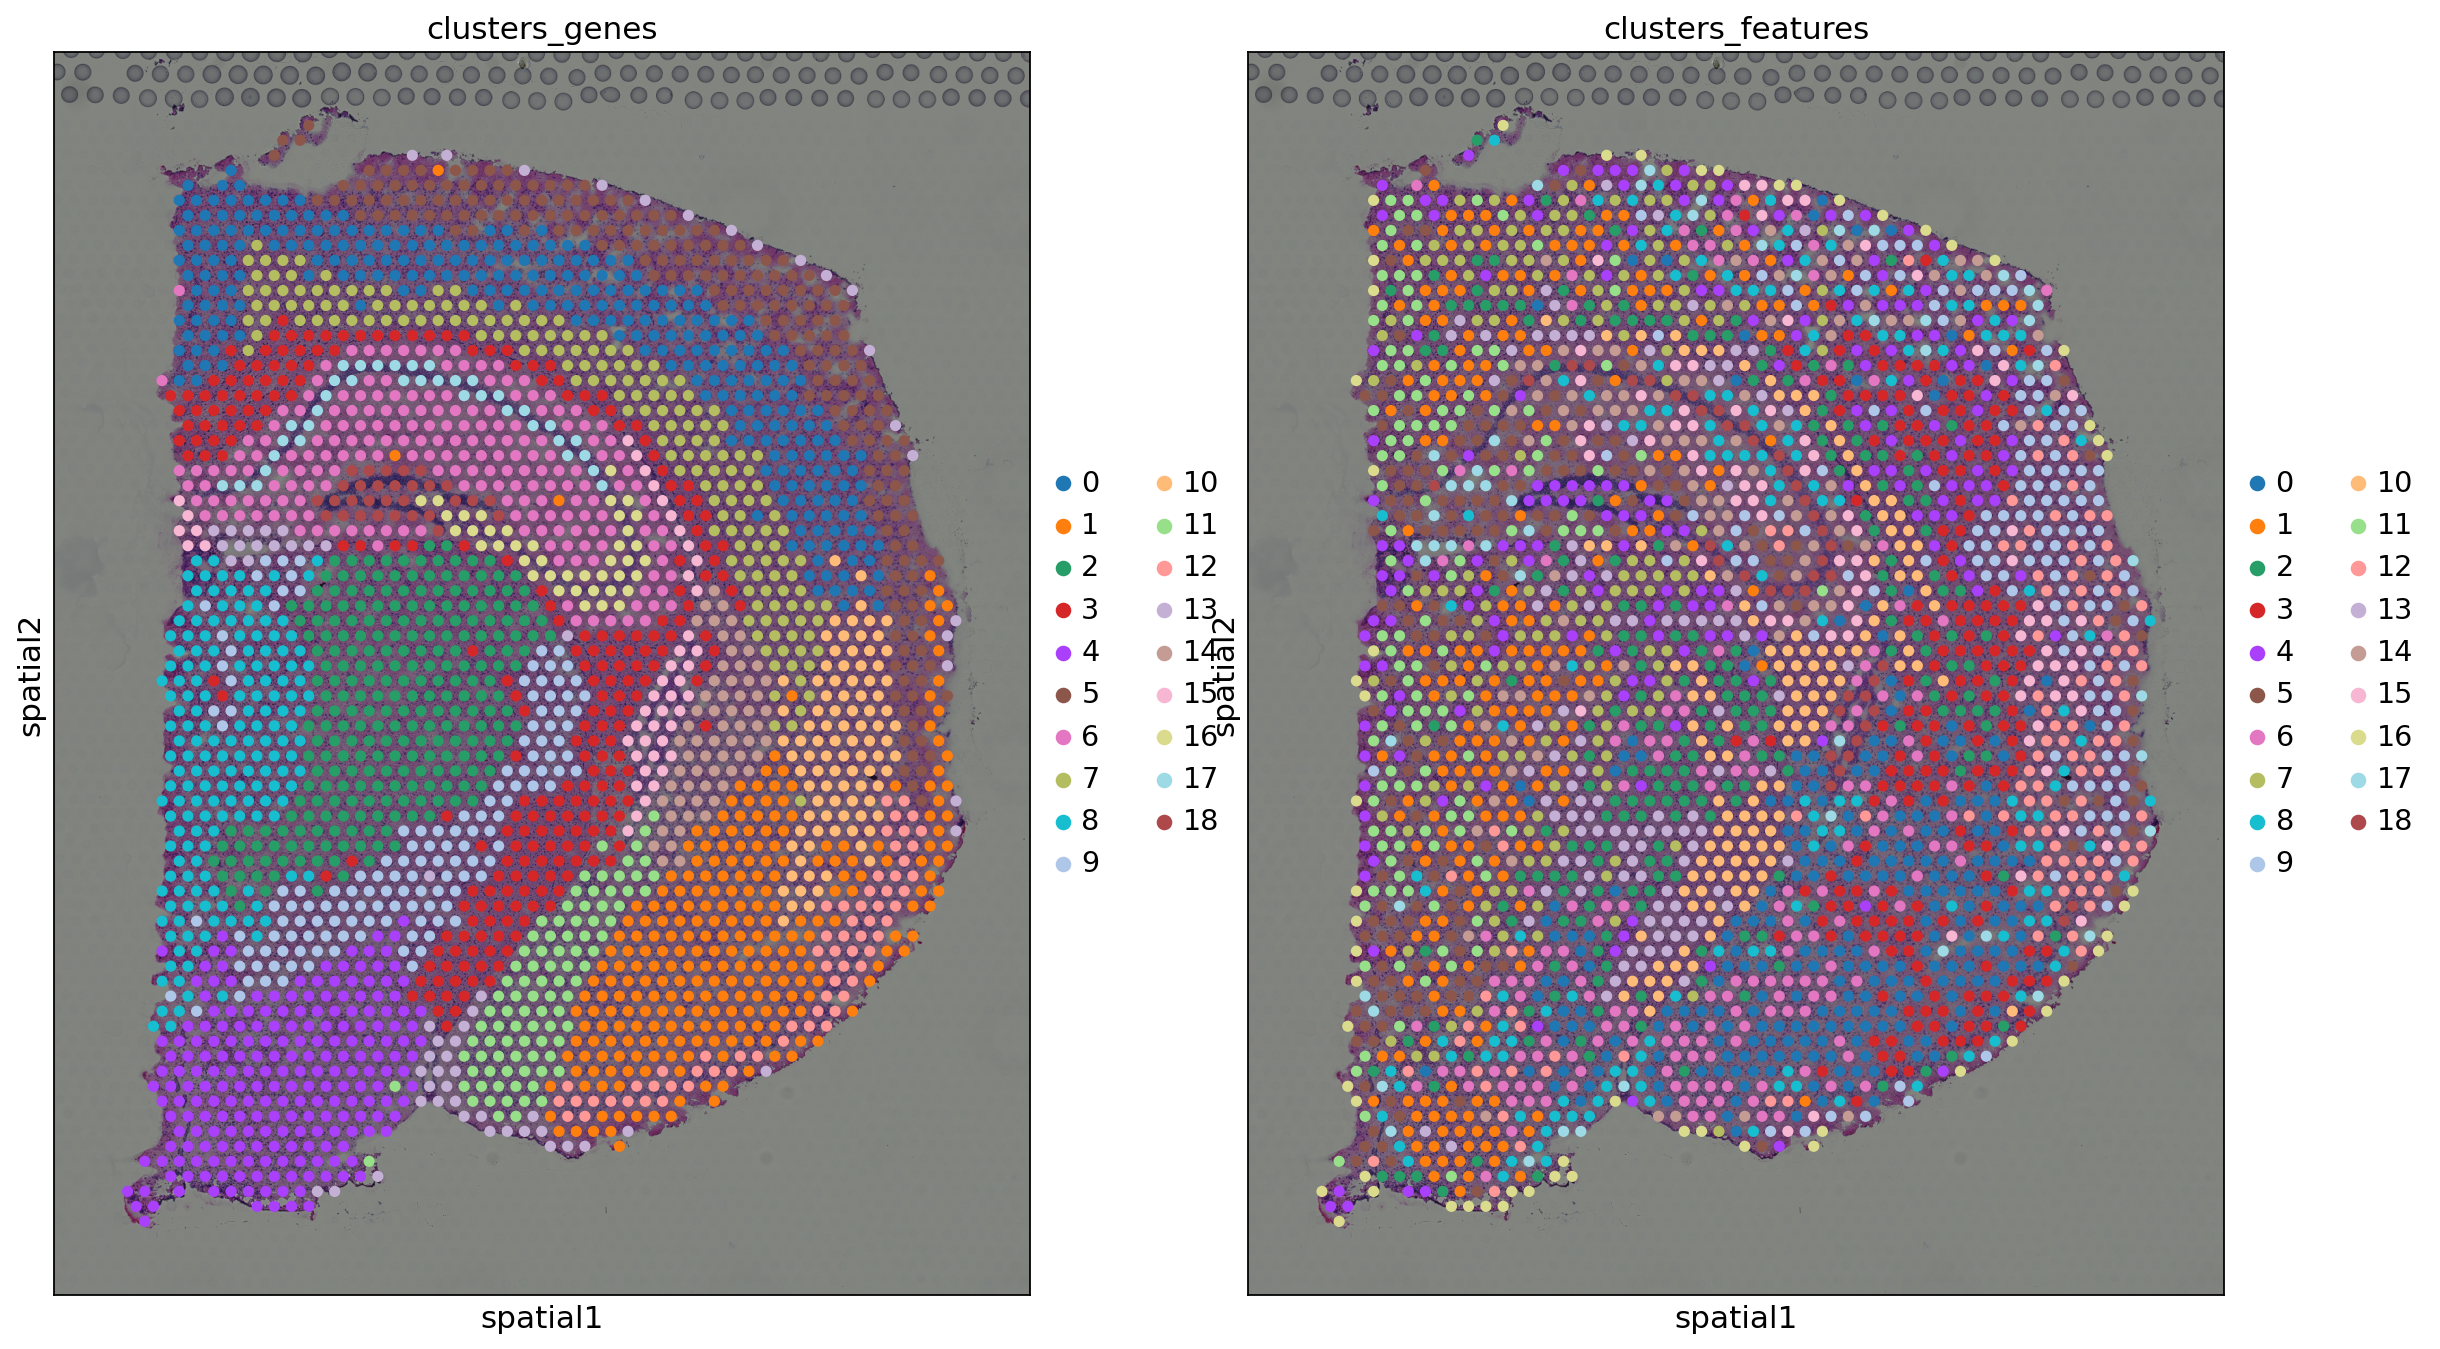

In [18]:
sc.set_figure_params(facecolor="white", figsize=(8, 15))
sc.pl.spatial(adata, color=['clusters_genes', 'clusters_features'], save='clustering_comparison.png')

#### "texture", "summary", "color_hist"

In [ ]:
sc.set_figure_params(facecolor="white", figsize=(8, 15))
sc.pl.spatial(adata, color=['clusters_genes', 'clusters_features'], save='clustering_comparison.png')

#### HOG features

In [ ]:
sc.set_figure_params(facecolor="white", figsize=(8, 15))
sc.pl.spatial(adata, color=['clusters_genes', 'clusters_features'], save='clustering_comparison.png')

## Evaluation: silhouette score
Between -1 and 1, 1 means most compact and different clusters

In [ ]:
import sklearn

In [ ]:
s = sklearn.metrics.silhouette_score(adata.obsm['X_pca'], adata.obs['clusters_genes'])
print(f"Silhouette score of gene-space clusters: {s}")

s = sklearn.metrics.silhouette_score(adata.obsm['X_features_pca'], adata.obs['clusters_features'])
print(f"Silhouette score of feature-space clusters: {s}")

## Evaluation: cluster overlap with GT (gene-space) clusters
adjusted rand score: 

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

`ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)`
The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [ ]:
sklearn.metrics.adjusted_rand_score(adata.obs['clusters_genes'], adata.obs['clusters_features'])